# Image Classification from the Scratch. 
* This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

* We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

# SETUP


In [2]:
# importing necessary modules 
import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from keras import layers

# Load and filter out corrupted images from the dataset

In [2]:
import os
# When working with lots of real-world image data, corrupted images are a common occurence. 
# Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

num_skipped = 0
for folder in ("Cat", 'Dog'):
    path = os.path.join("dataset", folder)
    for fname in os.listdir(path):
        fpath = os.path.join(path, fname)
        try:
            fobj = open(fpath,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped +=1
            # Deleting corrupted images 
            os.remove(fpath)

print (f"Deleted {num_skipped} images.")

Deleted 0 images.


# Generating Dataset


In [3]:
image_size = (180, 180)
batch_size = 32

# Training Dataset:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Pets",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Test Dataset:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Pets",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23427 files belonging to 3 classes.
Using 18742 files for training.
Found 23427 files belonging to 3 classes.
Using 4685 files for validation.


# Visualizing the Data

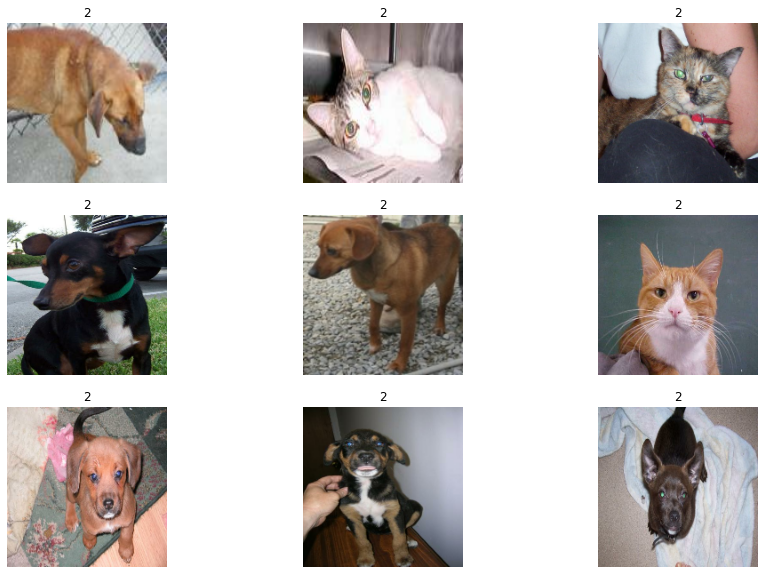

In [5]:
import matplotlib.pyplot as plt

plt.figure (figsize= (15,10))
for images , labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


# Using Image Data Augmentation: 


In [6]:
'''
When you don't have a large image dataset,
it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images,
such as random horizontal flipping or small random rotations. 
This helps expose the model to different aspects of the training data while slowing down overfitting.

'''

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

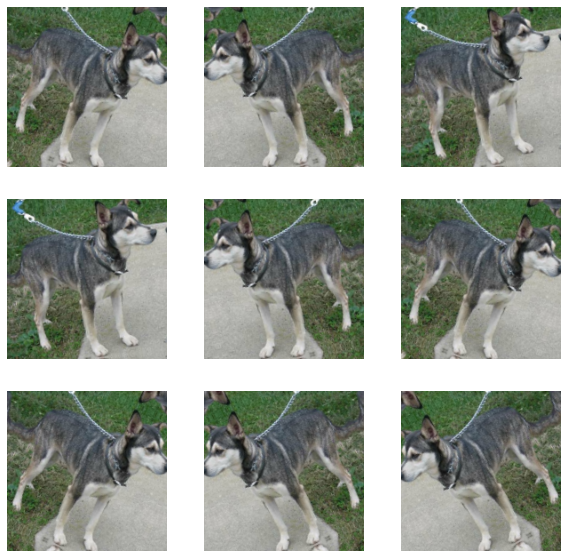

In [7]:
'''
Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:
'''
plt.figure(figsize= (10,10))
for images, _ in train_ds.take(1):
    for  i in range (9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the Data  
* Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [8]:
inputs = keras.Input(shape= (64,64,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [9]:
# Configuring the datasets for Performance 
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Building the Model: 
* We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

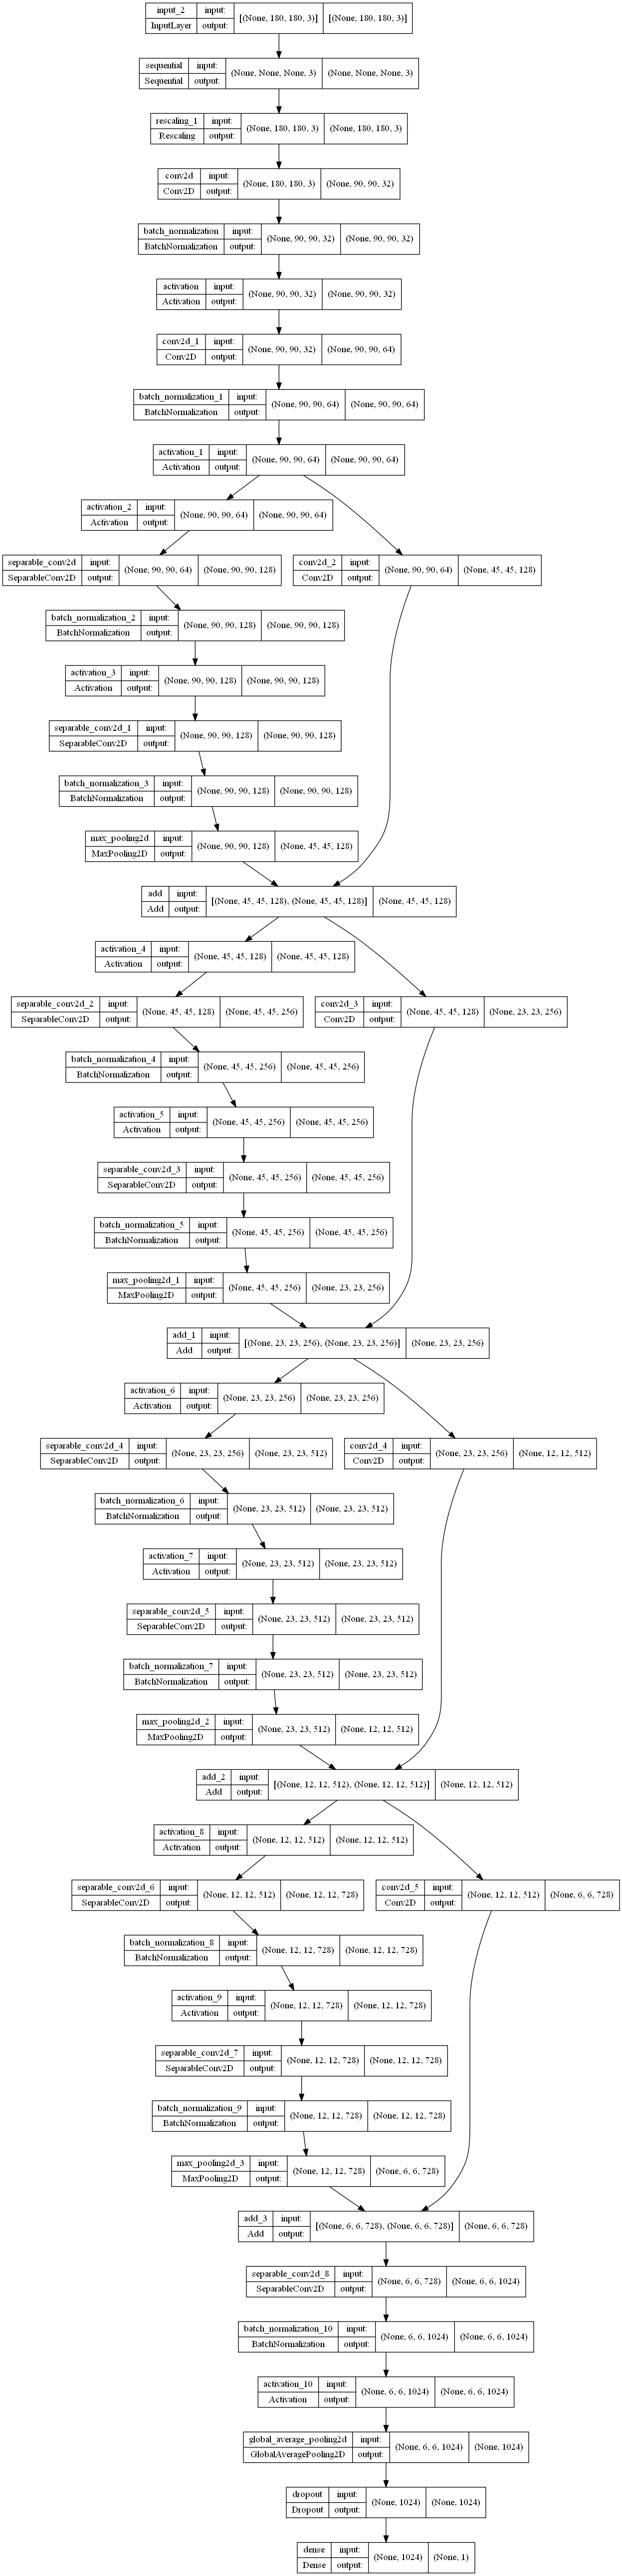

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [11]:
# Train the MODEL:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
 54/586 [=>............................] - ETA: 1:02:25 - loss: -14.3420 - accuracy: 0.0405

KeyboardInterrupt: 

In [14]:
# RUN INFERENCE ON NEW  DATA 
img = keras.preprocessing.image.load_img("Pets/Single_Image/Test1.jpg", target_size = image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)



This image is 0.39 percent cat and 99.61 percent dog.


# MODEL COMPLETE  
